In [1]:
import numpy as np
from utils_clean import generate_sample, DEOptim, RandomOptim, PSOOptim, visualize_meshgrid, get_likelihood_grids, visualize_pred_meshgrid
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

2022-08-09 10:36:28,750 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-08-09 10:36:28,751 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [2]:
dimensions = [3, 10, 15, 25, 35, 40, 45, 50]
target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)
results_thetas_per_dims = {}
results_logMargLikeli_pso = {}
results_mse_per_dims = {}
results_r2_per_dims = {}
results_mape_per_dims = {}
results_thetas_de = {}
results_logMargLikeli_de = {}
results_thetas_rs = {}
results_logMargLikeli_rs = {}

for d in dimensions:
    lower_bound = (-2.5,) * d
    upper_bound = (+1.5,) * d

    X, y = generate_sample(70, d, lower_bound, upper_bound, target_func)

    seed = np.random.RandomState(42)
    part = 10
    dim = d
    pso = PSOOptim(n_iters=100, n_particles=part, c1=0.5, c2=0.3, w=0.9, init_pos=(seed.rand(part, dim)*22)-11, visualize=True)
    gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,) * d))
    gpr_pso.fit(X.T, y[...,None])
    y_pred = gpr_pso.predict(X.T) 
    results_logMargLikeli_pso[d] = gpr_pso.log_marginal_likelihood_value_

    de = DEOptim()
    gpr_de = GaussianProcessRegressor(optimizer=de.optimize, kernel=RBF(length_scale=(1,)*d))
    gpr_de.fit(X.T, y[...,None])
    y_pred = gpr_de.predict(X.T)

    results_thetas_de[d] = gpr_de.kernel_.theta
    results_logMargLikeli_de[d] = gpr_de.log_marginal_likelihood_value_

    rs = RandomOptim(maxiter=1000, visualize=True)
    gpr_rs = GaussianProcessRegressor(optimizer=rs.optimize, kernel=RBF(length_scale=(1,)*d))
    gpr_rs.fit(X.T, y[...,None])
    y_pred = gpr_rs.predict(X.T)

    results_thetas_rs[d] = gpr_de.kernel_.theta
    results_logMargLikeli_rs[d] = gpr_de.log_marginal_likelihood_value_

    results_thetas_per_dims[d] = gpr_pso.kernel_.theta
    results_logMargLikeli_pso[d] = gpr_pso.log_marginal_likelihood_value_
    results_mse_per_dims[d] = mean_squared_error(y, y_pred)
    results_r2_per_dims[d] = r2_score(y, y_pred)
    results_mape_per_dims[d] = mean_absolute_percentage_error(y, y_pred)

2022-08-09 10:36:29,060 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=7.18e+4
2022-08-09 10:36:30,963 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71818.54689126505, best pos: [-2.34222273  0.33221477  1.10127132]
2022-08-09 10:36:32,148 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.03e+5
2022-08-09 10:36:35,256 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 302672.95272790355, best pos: [ 1.51012985  1.58563353  0.26031937  5.0786967   1.46160918  1.46012529
 -0.17774167  8.12344348  1.95967958  1.09271273]
2022-08-09 10:36:37,883 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=6.91

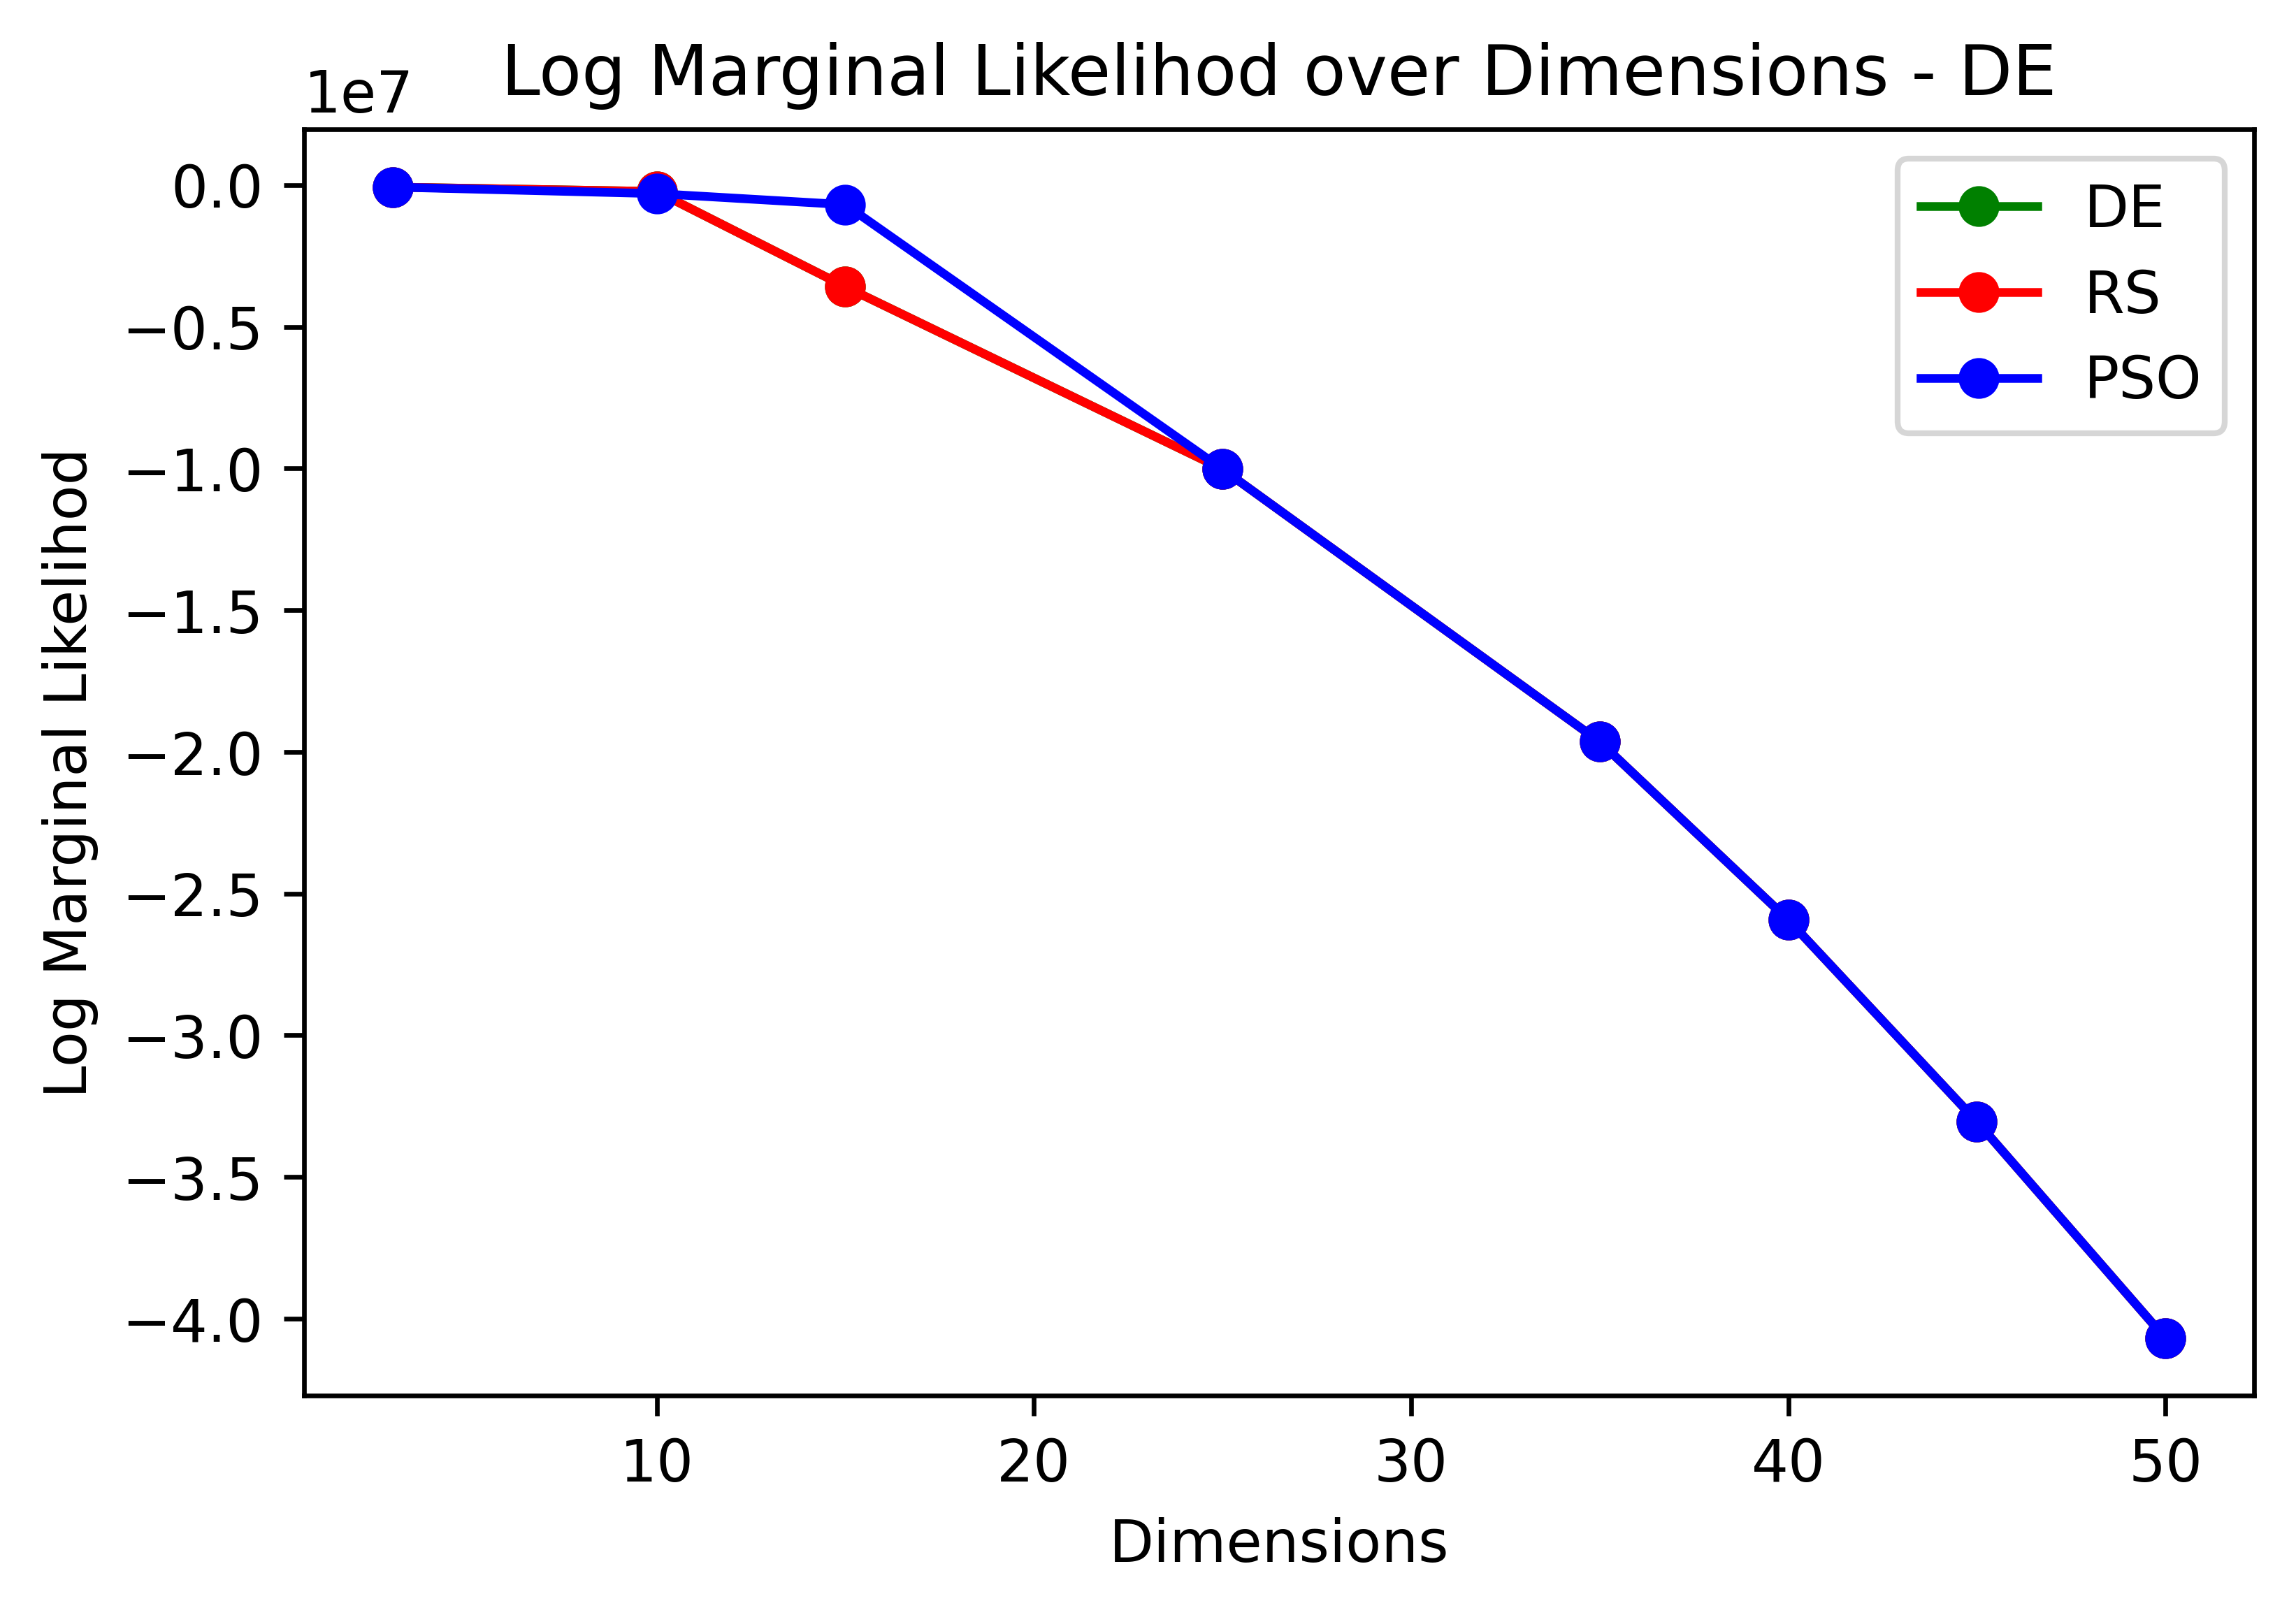

In [3]:
X_plot = results_logMargLikeli_de.keys()
fig = plt.figure(dpi=600)
plt.plot(X_plot, results_logMargLikeli_de.values(), marker='o', label="DE", color="g")
plt.plot(X_plot, results_logMargLikeli_rs.values(), marker='o', label="RS", color="r")
plt.plot(X_plot, results_logMargLikeli_pso.values(), marker='o', label="PSO", color="b")
plt.title("Log Marginal Likelihod over Dimensions - DE")
plt.xlabel("Dimensions")
plt.ylabel("Log Marginal Likelihod ")
plt.legend()
plt.show()

In [4]:
df_results = pd.DataFrame({"Iteration":[], "Dimension":[], "DE_ML":[], "PSO_ML":[], "RS_ML":[]})

In [5]:
dimensions = [5, 10, 15, 20]
target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)
results_logMargLikeli_per_dims = {}
results_logMargLikeli_de = {}
results_logMargLikeli_rs = {}

for i in range(20):
    for d in dimensions:
        seed = np.random.RandomState(i)
        lower_bound = (-2.5,) * d
        upper_bound = (+1.5,) * d

        X, y = generate_sample(70, d, lower_bound, upper_bound, target_func)

        part = 10
        dim = d
        pso = PSOOptim(n_iters=100, n_particles=part, c1=0.5, c2=0.3, w=0.9, init_pos=(seed.rand(part, dim)*22)-11, visualize=True)
        gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,) * d))
        gpr_pso.fit(X.T, y[...,None])
        
        optim = DEOptim()
        gpr_de = GaussianProcessRegressor(optimizer=optim.optimize, kernel=RBF(length_scale=(1,)*d))
        gpr_de.fit(X.T, y[...,None])
      
        rs = RandomOptim(maxiter=1000, visualize=True, random_state=i)
        gpr_rs = GaussianProcessRegressor(optimizer=rs.optimize, kernel=RBF(length_scale=(1,)*d))
        gpr_rs.fit(X.T, y[...,None])
       
        df_results.loc[len(df_results)] = [i, d, gpr_de.log_marginal_likelihood_value_, gpr_pso.log_marginal_likelihood_value_, gpr_rs.log_marginal_likelihood_value_]
    

2022-08-09 10:37:35,683 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=1.17e+5
2022-08-09 10:37:37,983 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 116812.87550326867, best pos: [-0.07952724  0.03569742  3.78843351 -0.30400529  1.25077199]
2022-08-09 10:37:39,210 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.07e+5
2022-08-09 10:37:42,066 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 307373.2181515653, best pos: [0.39169456 6.45331216 2.26472906 1.4976207  0.2768437  2.10913624
 2.7645598  0.9234124  1.69730783 0.43953829]
2022-08-09 10:37:44,548 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, 

In [6]:
df_results["Iteration"] = df_results["Iteration"].astype(int)
df_results

,Iteration,Dimension,DE_ML,PSO_ML,RS_ML
0,0,5.0,-1.034063e+05,-1.168129e+05,-1.729504e+05
1,0,10.0,-2.426999e+05,-3.073732e+05,-7.161680e+05
2,0,15.0,-3.587482e+06,-6.027284e+05,-3.577498e+06
3,0,20.0,-6.437604e+06,-1.248328e+06,-6.437604e+06
4,1,5.0,-1.022497e+05,-1.167537e+05,-1.538717e+05
...,...,...,...,...,...
75,18,20.0,-6.437604e+06,-4.607159e+06,-6.437239e+06
76,19,5.0,-1.022497e+05,-1.224762e+05,-1.422706e+05
77,19,10.0,-2.359943e+05,-2.458015e+05,-4.282240e+05
78,19,15.0,-4.350106e+05,-5.228630e+05,-3.524013e+06


In [7]:
df_1 = df_results[["Dimension","DE_ML"]]
df_1["Optimizer"] = "DE"
df_1=df_1.rename(columns={"DE_ML": "Log Likelihood"}, inplace=False)
df_2 = df_results[["Dimension","PSO_ML"]]
df_2["Optimizer"] = "PSO"
df_2=df_2.rename(columns={"PSO_ML": "Log Likelihood"}, inplace=False)
df_3 = df_results[["Dimension","RS_ML"]]
df_3["Optimizer"] = "RS"
df_3=df_3.rename(columns={"RS_ML": "Log Likelihood"}, inplace=False)

C:\Users\Pascal\AppData\Local\Temp\ipykernel_30268\2423643525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["Optimizer"] = "DE"
C:\Users\Pascal\AppData\Local\Temp\ipykernel_30268\2423643525.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["Optimizer"] = "PSO"
C:\Users\Pascal\AppData\Local\Temp\ipykernel_30268\2423643525.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [8]:
df_results_ = pd.concat((df_1, df_2, df_3))
df_results_

,Dimension,Log Likelihood,Optimizer
0,5.0,-1.034063e+05,DE
1,10.0,-2.426999e+05,DE
2,15.0,-3.587482e+06,DE
3,20.0,-6.437604e+06,DE
4,5.0,-1.022497e+05,DE
...,...,...,...
75,20.0,-6.437239e+06,RS
76,5.0,-1.422706e+05,RS
77,10.0,-4.282240e+05,RS
78,15.0,-3.524013e+06,RS


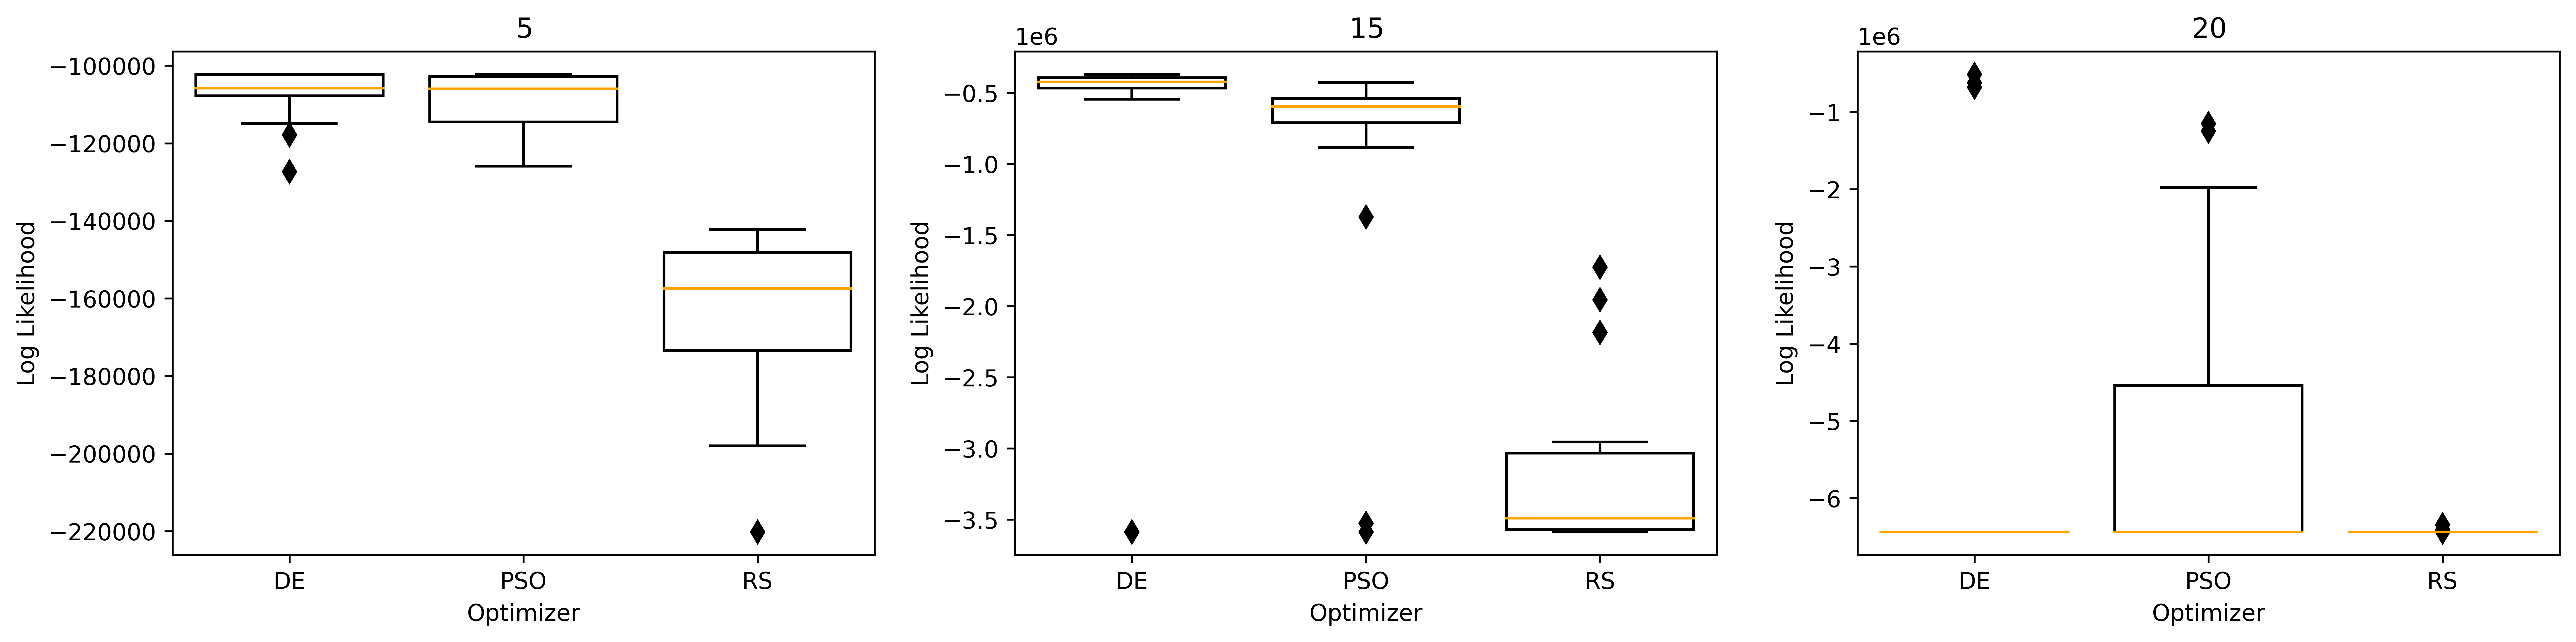

In [19]:
import seaborn as sns

if 10 in dimensions:
    dimensions.remove(10)

PROPS = {'boxprops':{'facecolor': "white", 'edgecolor':'black'},
'medianprops':{'color':'orange'},
'whiskerprops':{'color':'black'},
'capprops':{'color':'black'}
}
i= 0
plt.figure(figsize=(25,4), dpi=600)
for f in dimensions:
    i+=1
    plt.subplot(1,4,i)
    sns.boxplot(x="Optimizer", y="Log Likelihood", data=df_results_.loc[df_results["Dimension"]==f], color="white", linewidth=1.2, flierprops = dict(markerfacecolor='black', markersize=8,
                  markeredgecolor='none'), **PROPS)
    plt.title(f'${f}$')


In [10]:
std_mean_results = df_results_.groupby(["Dimension", "Optimizer"], as_index=False).agg({'Log Likelihood':['mean','std']})


In [11]:
std_mean_results

Dimension Optimizer Log Likelihood              
                                 mean           std
0        5.0        DE  -1.074429e+05  6.995106e+03
1        5.0       PSO  -1.087217e+05  7.338909e+03
2        5.0        RS  -1.643764e+05  2.049396e+04
3       10.0        DE  -2.441641e+05  1.766856e+04
4       10.0       PSO  -2.841461e+05  3.955680e+04
5       10.0        RS  -5.979373e+05  1.281385e+05
6       15.0        DE  -8.973367e+05  1.160210e+06
7       15.0       PSO  -9.322381e+05  9.194786e+05
8       15.0        RS  -3.197962e+06  5.766993e+05
9       20.0        DE  -5.562655e+06  2.137076e+06
10      20.0       PSO  -5.384631e+06  1.847574e+06
11      20.0        RS  -6.431317e+06  2.189631e+04

In [12]:
DE_results = std_mean_results.loc[std_mean_results['Optimizer'] == "DE"]
RS_results = std_mean_results.loc[std_mean_results['Optimizer'] == "RS"]
PSO_results = std_mean_results.loc[std_mean_results['Optimizer'] == "PSO"]

In [13]:
from scipy.stats import t
DE_results["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * DE_results["Log Likelihood"]["std"] + DE_results["Log Likelihood"]["mean"]
DE_results["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * DE_results["Log Likelihood"]["std"] + DE_results["Log Likelihood"]["mean"]

RS_results["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * RS_results["Log Likelihood"]["std"] + RS_results["Log Likelihood"]["mean"]
RS_results["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * RS_results["Log Likelihood"]["std"] + RS_results["Log Likelihood"]["mean"]

PSO_results["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * PSO_results["Log Likelihood"]["std"] + PSO_results["Log Likelihood"]["mean"]
PSO_results["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * PSO_results["Log Likelihood"]["std"] + PSO_results["Log Likelihood"]["mean"]

C:\Users\Pascal\AppData\Local\Temp\ipykernel_30268\1671422384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_results["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * DE_results["Log Likelihood"]["std"] + DE_results["Log Likelihood"]["mean"]
C:\Users\Pascal\AppData\Local\Temp\ipykernel_30268\1671422384.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_results["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * DE_results["Log Likelihood"]["std"] + DE_results["Log Likelihood"]["mean"]
C:\Users\Pascal\AppData\Loc

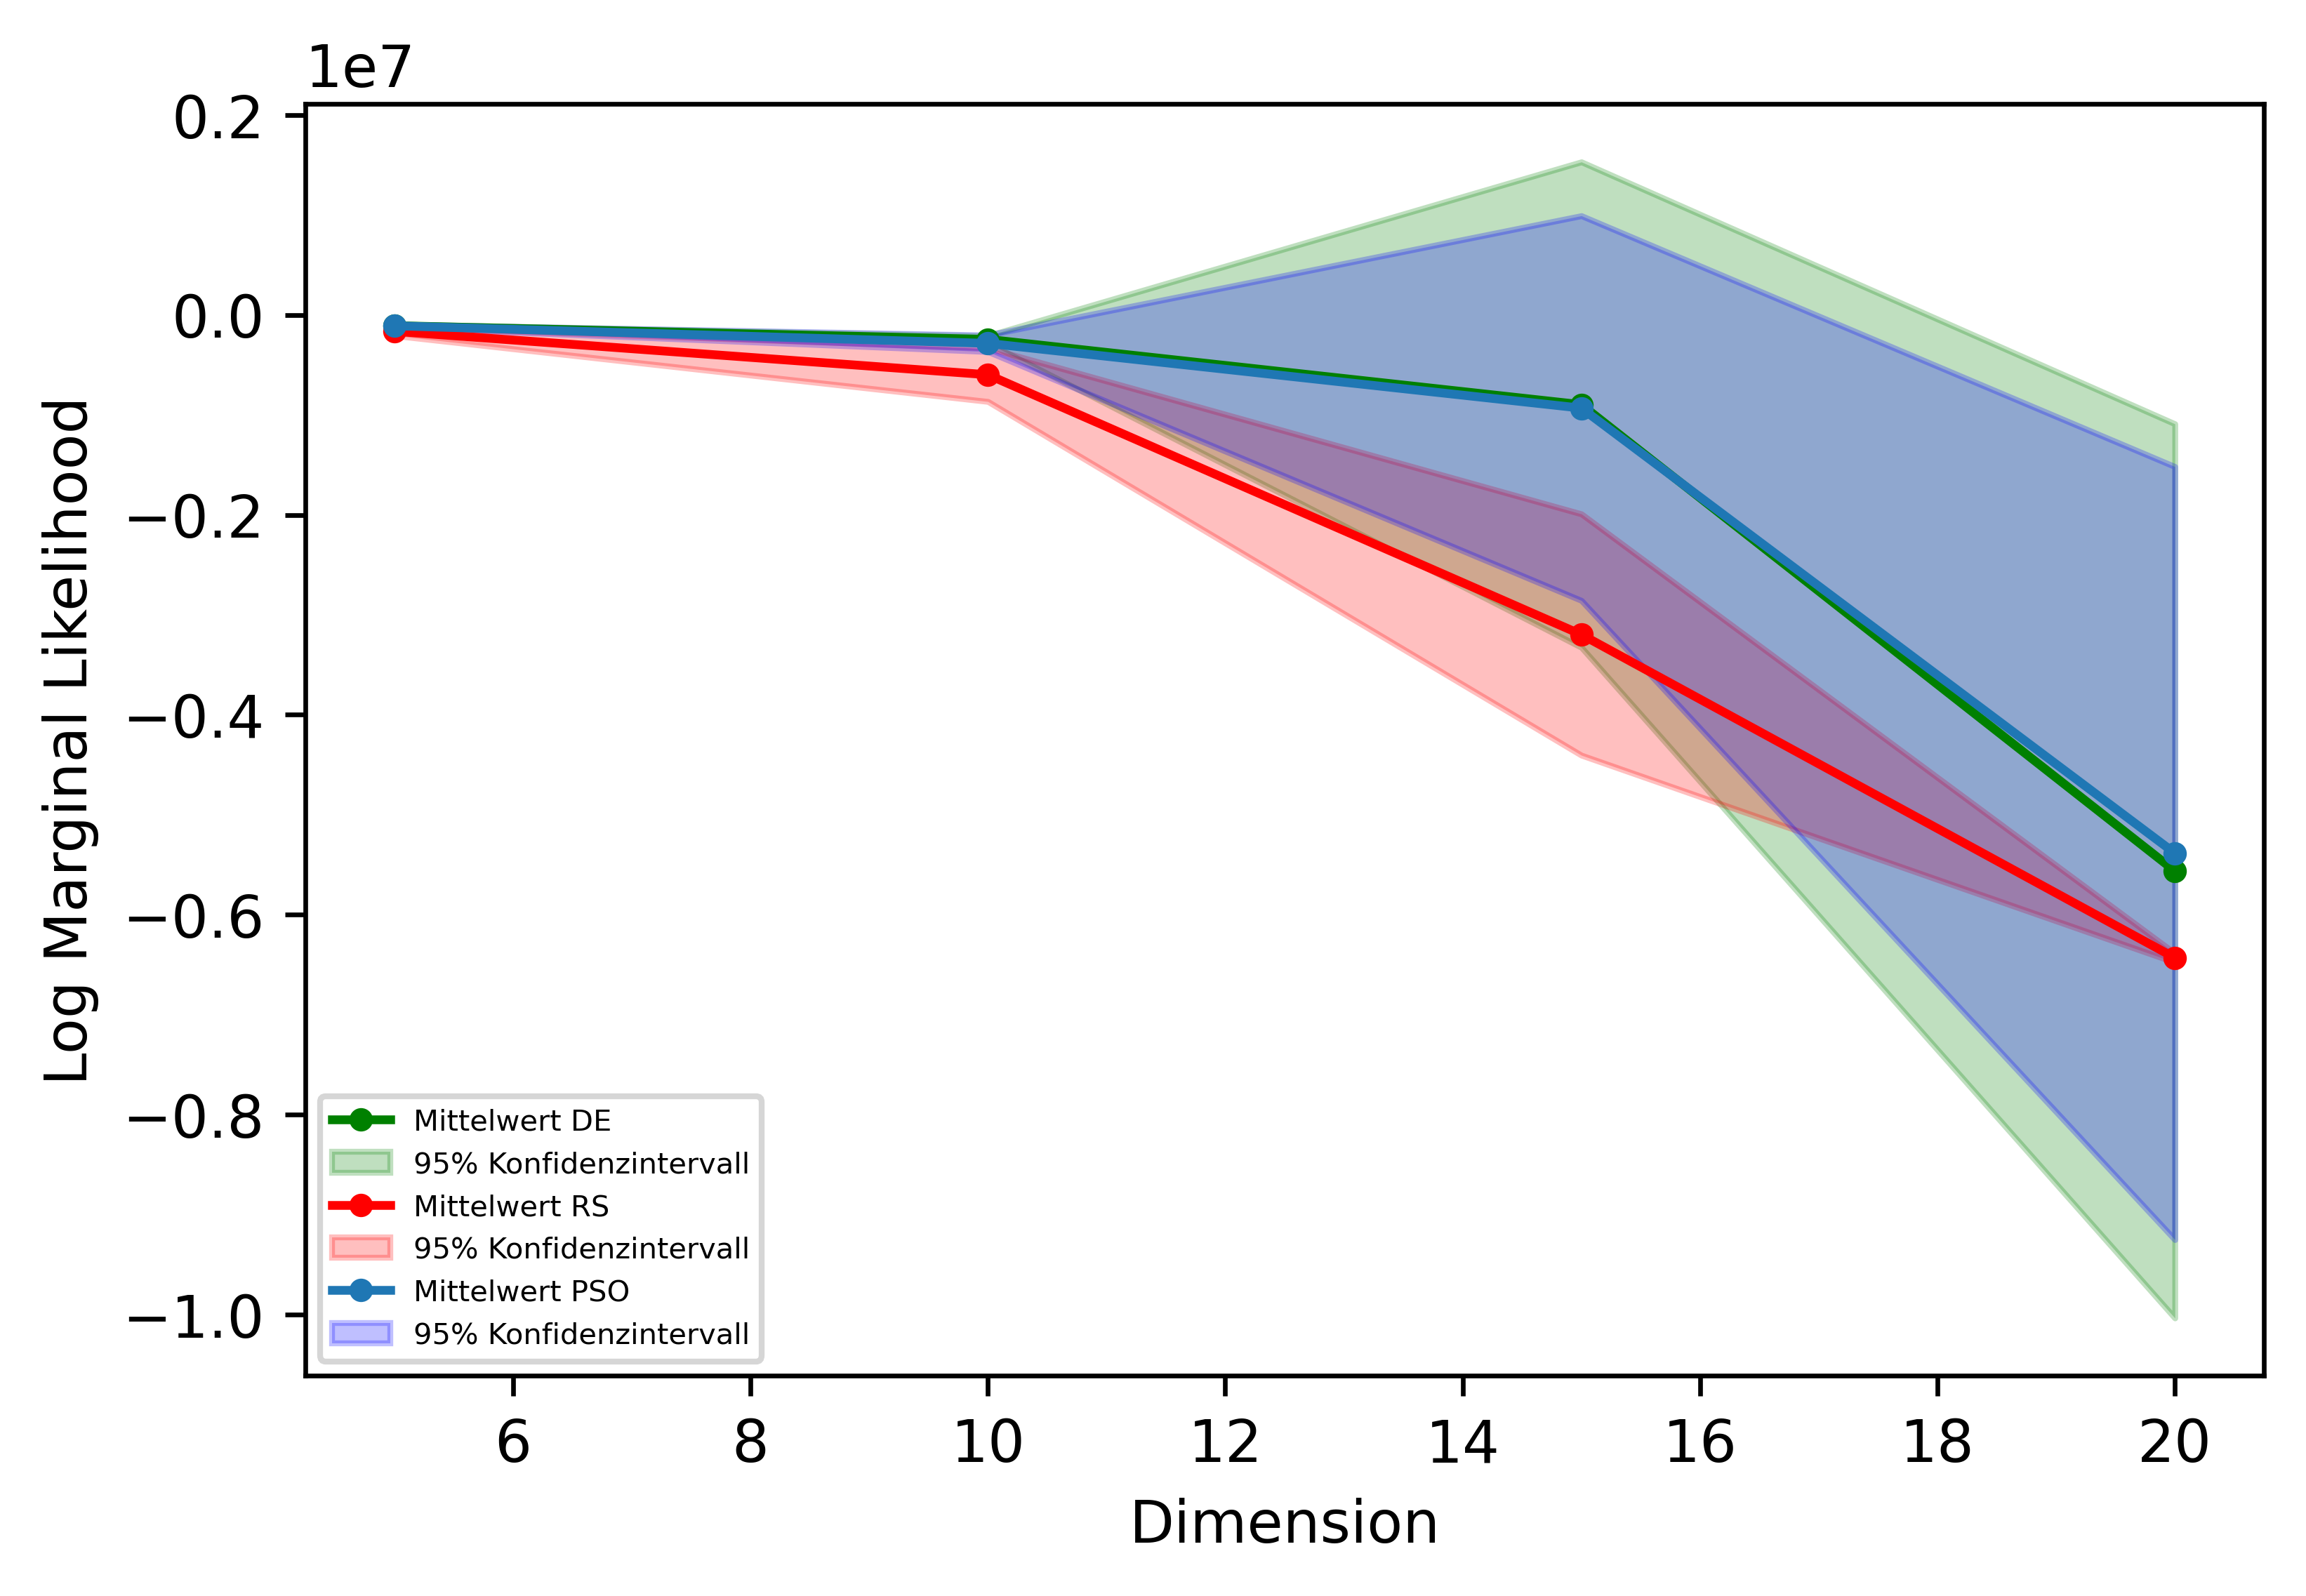

In [27]:
plt.figure(dpi=600)
plt.plot(DE_results["Dimension"], DE_results["Log Likelihood"]["mean"], marker="o", markersize=3, color="g", label="Mittelwert DE")
plt.fill_between(DE_results["Dimension"], DE_results["conf_95_u"], DE_results["conf_95_o"], color="g", alpha=.25, label="95% Konfidenzintervall")

plt.plot(RS_results["Dimension"], RS_results["Log Likelihood"]["mean"], marker="o", markersize=3, color="r", label="Mittelwert RS")
plt.fill_between(RS_results["Dimension"], RS_results["conf_95_u"], RS_results["conf_95_o"], color="r", alpha=.25, label="95% Konfidenzintervall")

plt.plot(PSO_results["Dimension"], PSO_results["Log Likelihood"]["mean"], marker="o", markersize=3, label="Mittelwert PSO")
plt.fill_between(PSO_results["Dimension"], PSO_results["conf_95_u"], PSO_results["conf_95_o"], color="b", alpha=.25, label="95% Konfidenzintervall")

plt.ylabel("Log Marginal Likelihood")
plt.xlabel("Dimension")
plt.legend(fontsize=5, loc='lower left')